# Network Analysis for Information Retrieval - Part 1

Elyes KHALFALLAH & Mohammed ali EL ADLOUNI

16/03/2025

---

---


## 0. Etapes préliminaires


In [1]:
# Useful libraries
import nltk
import re
import numpy as np
import pandas as pd
from fonctions import *

# Downloading the necessary datasets for the nltk library
# Only download if necessary
nltk.download("stopwords", quiet=True)
nltk.download("wordnet", quiet=True)


True

In [2]:
# Import data from data_project.csv
data = pd.read_csv("data_project.csv", sep="\t")

# Show the first 5 rows of the data
data.head()


,venue,abstract,authors,n_citation,references,title,year,id,class
0,international conference on human-computer int...,The purpose of this study is to develop a lear...,"['Makoto Satoh', 'Ryo Muramatsu', 'Mizue Kayam...",0,"['51c7e02e-f5ed-431a-8cf5-f761f266d4be', '69b6...",Preliminary Design of a Network Protocol Learn...,2013,00127ee2-cb05-48ce-bc49-9de556b93346,3
1,visual analytics science and technology,This paper describes the design and implementa...,"['Gareth Beale', 'Graeme Earl']",50,"['10482dd3-4642-4193-842f-85f3b70fcf65', '3133...",A methodology for the physically accurate visu...,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821,3
2,pattern recognition and machine intelligence,This article applied GARCH model instead AR or...,"['Altaf Hossain', 'Faisal Zaman', 'Mohammed Na...",50,"['2d84c0f2-e656-4ce7-b018-90eda1c132fe', 'a083...","Comparison of GARCH, Neural Network and Suppor...",2009,001c8744-73c4-4b04-9364-22d31a10dbf1,4
3,international conference on computer graphics ...,NaN,"['Rafael Álvarez', 'Leandro Tortosa', 'José-Fr...",0,NaN,COMPARING GNG3D AND QUADRIC ERROR METRICS METH...,2009,005ce28f-ed77-4e97-afdc-a296137186a1,5
4,international symposium on computer and inform...,NaN,"['Guzin Ulutas', 'Mustafa Ulutas', 'Vasif V. N...",0,"['5626736c-e434-4e2d-8405-54940fab88ab', '8e87...",Improved Secret Image Sharing Method By Encodi...,2011,00701b05-684f-45f9-b281-425abfec482c,8


In [3]:
data.shape


(40596, 9)

In [4]:
data["class"].unique()


array([3, 4, 5, 8, 7, 1, 6, 2])

---

## 1. Prétraitement des données

### 1.1. Générer le texte sur lequel nous travaillerons


In [5]:
# Fill NaN values in 'abstract' and 'title' with empty strings and create 'text'
data_text = data.fillna({"abstract": "", "title": ""})

# Concatenate 'title' and 'abstract' into 'text'
data_text["text"] = " " + data_text["title"] + " " + data_text["abstract"]

# Reposition 'text' as the first column
cols = ["text"] + [col for col in data_text.columns if col != "text"]
data_text = data_text[cols]

# Show the first 5 rows of the cleaned data
data_text.head()


,text,venue,abstract,authors,n_citation,references,title,year,id,class
0,Preliminary Design of a Network Protocol Lear...,international conference on human-computer int...,The purpose of this study is to develop a lear...,"['Makoto Satoh', 'Ryo Muramatsu', 'Mizue Kayam...",0,"['51c7e02e-f5ed-431a-8cf5-f761f266d4be', '69b6...",Preliminary Design of a Network Protocol Learn...,2013,00127ee2-cb05-48ce-bc49-9de556b93346,3
1,A methodology for the physically accurate vis...,visual analytics science and technology,This paper describes the design and implementa...,"['Gareth Beale', 'Graeme Earl']",50,"['10482dd3-4642-4193-842f-85f3b70fcf65', '3133...",A methodology for the physically accurate visu...,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821,3
2,"Comparison of GARCH, Neural Network and Suppo...",pattern recognition and machine intelligence,This article applied GARCH model instead AR or...,"['Altaf Hossain', 'Faisal Zaman', 'Mohammed Na...",50,"['2d84c0f2-e656-4ce7-b018-90eda1c132fe', 'a083...","Comparison of GARCH, Neural Network and Suppor...",2009,001c8744-73c4-4b04-9364-22d31a10dbf1,4
3,COMPARING GNG3D AND QUADRIC ERROR METRICS MET...,international conference on computer graphics ...,,"['Rafael Álvarez', 'Leandro Tortosa', 'José-Fr...",0,NaN,COMPARING GNG3D AND QUADRIC ERROR METRICS METH...,2009,005ce28f-ed77-4e97-afdc-a296137186a1,5
4,Improved Secret Image Sharing Method By Encod...,international symposium on computer and inform...,,"['Guzin Ulutas', 'Mustafa Ulutas', 'Vasif V. N...",0,"['5626736c-e434-4e2d-8405-54940fab88ab', '8e87...",Improved Secret Image Sharing Method By Encodi...,2011,00701b05-684f-45f9-b281-425abfec482c,8


In [6]:
# Show 'text' column of the first row
print(data_text["text"][0])


 Preliminary Design of a Network Protocol Learning Tool Based on the Comprehension of High School Students: Design by an Empirical Study Using a Simple Mind Map The purpose of this study is to develop a learning tool for high school students studying the scientific aspects of information and communication net- works. More specifically, we focus on the basic principles of network proto- cols as the aim to develop our learning tool. Our tool gives students hands-on experience to help understand the basic principles of network protocols.


### 1.2. Prétrairements poussés


Now, we want to build an index for the data. To do so, we'll :

1. Remove punctuation
2. Lowercase everything
3. Remove useless spaces
4. Remove stop-words
5. Normalize the data (lemmatization)
6. Remove outliers


#### Punctuation removal :


In [7]:
# Remove all puntuation from 'text' using regex
data_text["text"] = data_text["text"].apply(lambda x: re.sub(r"[^\w\s]", " ", x))

# Show 'text' column of the first row
print(data_text["text"][0])


 Preliminary Design of a Network Protocol Learning Tool Based on the Comprehension of High School Students  Design by an Empirical Study Using a Simple Mind Map The purpose of this study is to develop a learning tool for high school students studying the scientific aspects of information and communication net  works  More specifically  we focus on the basic principles of network proto  cols as the aim to develop our learning tool  Our tool gives students hands on experience to help understand the basic principles of network protocols 


#### Lowercase :


In [8]:
# Convert 'text' to lowercase
data_text["text"] = data_text["text"].str.lower()

# Show 'text' column of the first row
print(data_text["text"][0])


 preliminary design of a network protocol learning tool based on the comprehension of high school students  design by an empirical study using a simple mind map the purpose of this study is to develop a learning tool for high school students studying the scientific aspects of information and communication net  works  more specifically  we focus on the basic principles of network proto  cols as the aim to develop our learning tool  our tool gives students hands on experience to help understand the basic principles of network protocols 


#### Spaces :


In [9]:
# Remove useless spaces using regex
data_text["text"] = data_text["text"].apply(lambda x: re.sub(r"\s+", " ", x).strip())

# Show 'text' column of the first row
print(data_text["text"][0])


preliminary design of a network protocol learning tool based on the comprehension of high school students design by an empirical study using a simple mind map the purpose of this study is to develop a learning tool for high school students studying the scientific aspects of information and communication net works more specifically we focus on the basic principles of network proto cols as the aim to develop our learning tool our tool gives students hands on experience to help understand the basic principles of network protocols


Lets see what we have for now


c:\Users\elyes\Desktop\MALIA\NetworkAnalysis_SearchEngine\fonctions.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(plot_words), y=list(counts), palette="rainbow_r")


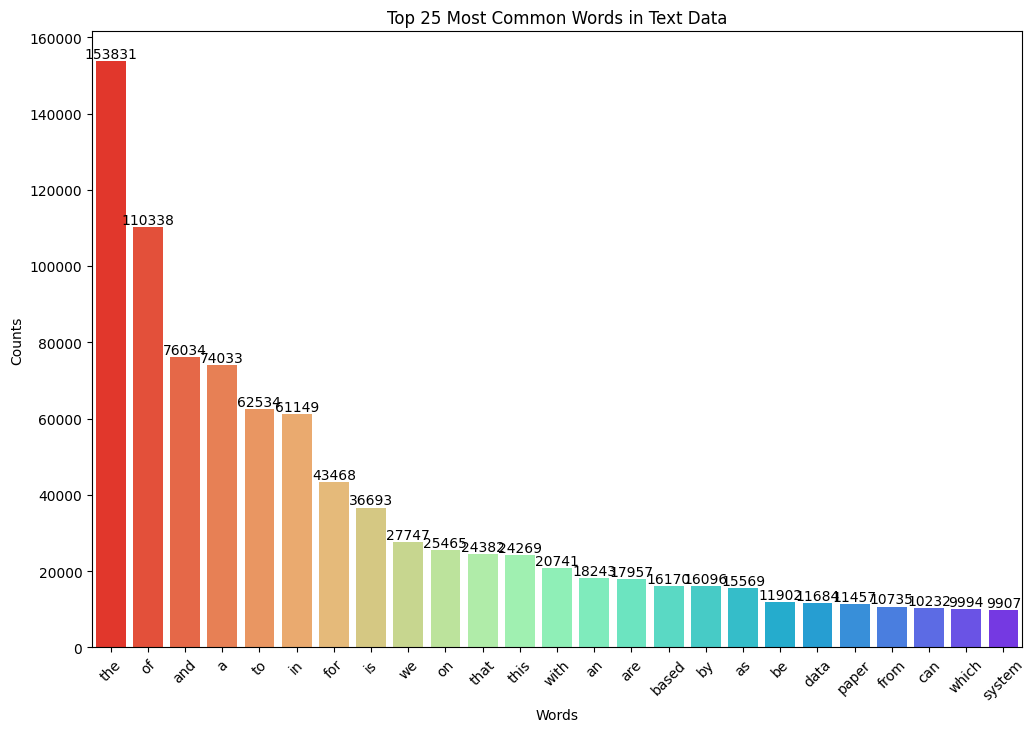

In [10]:
# Plot the most common words in the 'text' column of data_text
_ = word_occurrences(data_text, visualisation=True)


#### Stop-words :


In [11]:
# Remove stop words from 'text' column in data_text
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))
data_text["text"] = data_text["text"].apply(
    lambda x: " ".join([word for word in x.split() if word not in stop_words])
)


c:\Users\elyes\Desktop\MALIA\NetworkAnalysis_SearchEngine\fonctions.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(plot_words), y=list(counts), palette="rainbow_r")


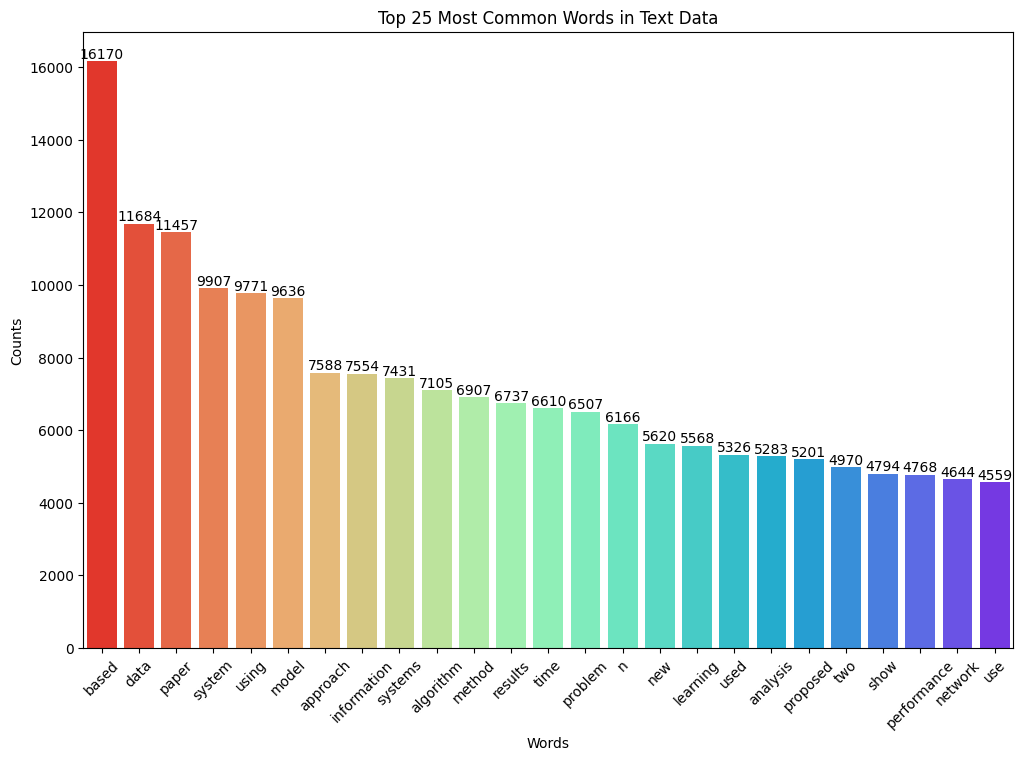

In [12]:
# Plot the most common words in the 'text' column of data_text
_ = word_occurrences(data_text, visualisation=True)


#### Normalize data (lemming) :


In [13]:
# Imports for lemmatization
from nltk.stem import WordNetLemmatizer

# Define lemmatizer tool
lemmatizer = WordNetLemmatizer()

# Show the first row to verify the lemmatization
print("Before :\n\t", data_text["text"][0])

# Apply lemmatization to each word in the text
data_text["text"] = data_text["text"].apply(
    lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()])
)

# Show the first row to verify the lemmatization
print("After :\n\t", data_text["text"][0])


Before :
	 preliminary design network protocol learning tool based comprehension high school students design empirical study using simple mind map purpose study develop learning tool high school students studying scientific aspects information communication net works specifically focus basic principles network proto cols aim develop learning tool tool gives students hands experience help understand basic principles network protocols
After :
	 preliminary design network protocol learning tool based comprehension high school student design empirical study using simple mind map purpose study develop learning tool high school student studying scientific aspect information communication net work specifically focus basic principle network proto col aim develop learning tool tool give student hand experience help understand basic principle network protocol


c:\Users\elyes\Desktop\MALIA\NetworkAnalysis_SearchEngine\fonctions.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(plot_words), y=list(counts), palette="rainbow_r")


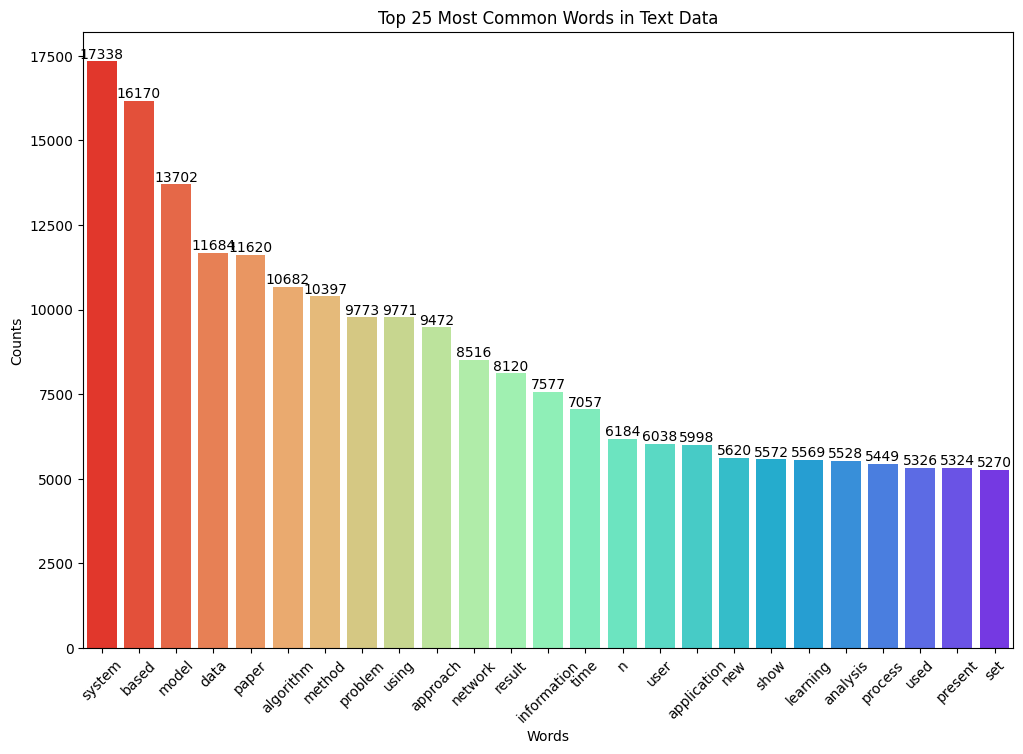

In [14]:
# Plot the most common words after lemmatization
_ = word_occurrences(data_text, visualisation=True)


#### Remove outliers :


C:\Users\elyes\AppData\Local\Temp\ipykernel_25708\499328142.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(list(word_occurrences(data_text).values()), palette="rainbow_r")


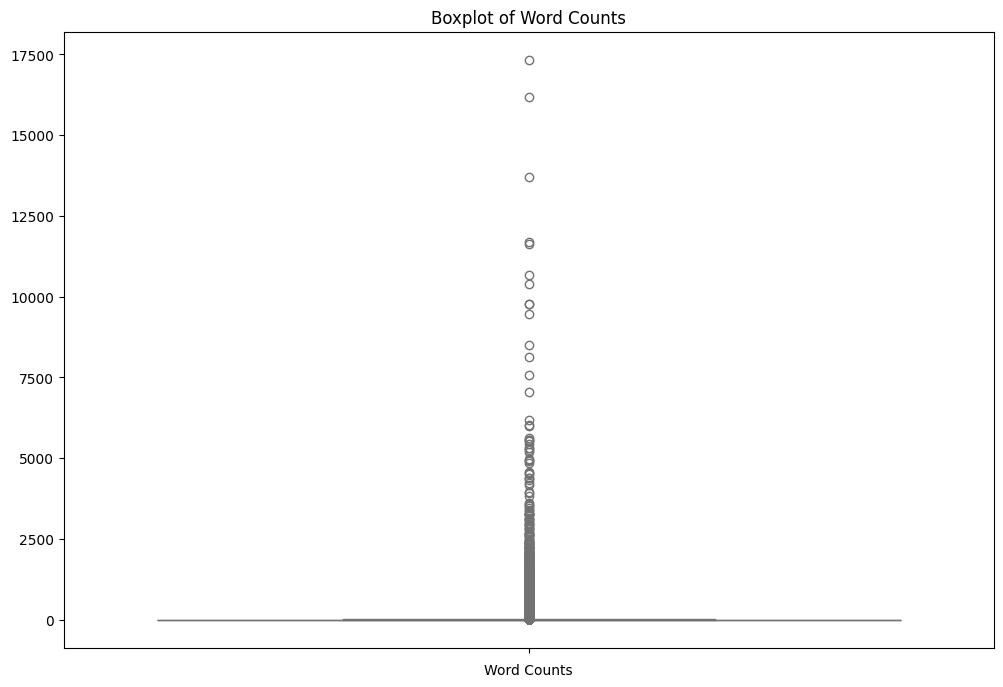

In [15]:
# See if there are outliers in occurrences
plt.figure(figsize=(12, 8))
sns.boxplot(list(word_occurrences(data_text).values()), palette="rainbow_r")
plt.xlabel("Word Counts")
plt.title("Boxplot of Word Counts")
plt.show()


In [16]:
occurrences = word_occurrences(data_text)

# Define limits as 10th and 90th percentiles
min_occurrences = pd.Series(occurrences).quantile(0.825)
max_occurrences = pd.Series(occurrences).quantile(0.955)

# momo test
min_occurrences = pd.Series(occurrences).quantile(0.825)
max_occurrences = pd.Series(occurrences).quantile(0.975)

print("Min occurrences:", min_occurrences)
print("Max occurrences:", max_occurrences)

# Identify words that have more than max_occurrences occurrences
high_outliers = {
    word: count for word, count in occurrences.items() if count > max_occurrences
}

# Identify words that have less than min_occurrences occurrences
low_outliers = {
    word: count for word, count in occurrences.items() if count < min_occurrences
}

# print("High outliers:", high_outliers)
# print("Low outliers:", low_outliers)

# Remove words that are in high_outliers and low_outliers from 'text' column in data_text
data_text["text"] = data_text["text"].apply(
    lambda x: " ".join(
        [
            word
            for word in x.split()
            if word not in high_outliers and word not in low_outliers
        ]
    )
)


Min occurrences: 10.0
Max occurrences: 241.34999999999854


In [17]:
before = len(occurrences)
after = len(word_occurrences(data_text))
difference = before - after

print("Number of words before removing outliers :", before)
print("Number of words after removing outliers  :", after)
print("Difference (amount of words removed)     :", difference)


Number of words before removing outliers : 55587
Number of words after removing outliers  : 8436
Difference (amount of words removed)     : 47151


C:\Users\elyes\AppData\Local\Temp\ipykernel_25708\499328142.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(list(word_occurrences(data_text).values()), palette="rainbow_r")


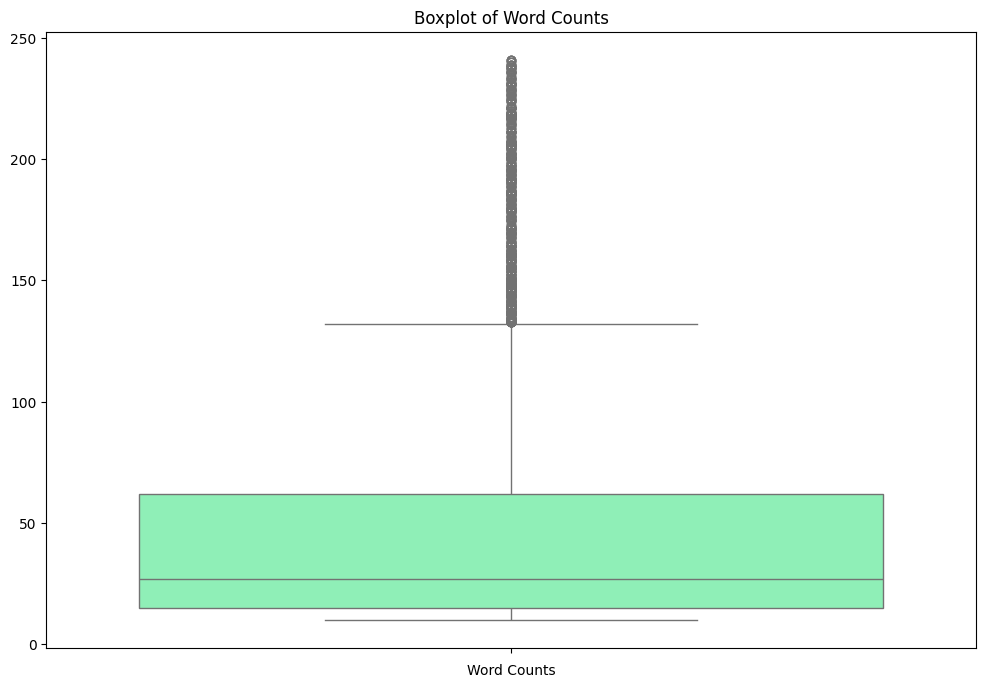

In [18]:
# See if there are outliers in occurrences
plt.figure(figsize=(12, 8))
sns.boxplot(list(word_occurrences(data_text).values()), palette="rainbow_r")
plt.xlabel("Word Counts")
plt.title("Boxplot of Word Counts")
plt.show()


c:\Users\elyes\Desktop\MALIA\NetworkAnalysis_SearchEngine\fonctions.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(plot_words), y=list(counts), palette="rainbow_r")


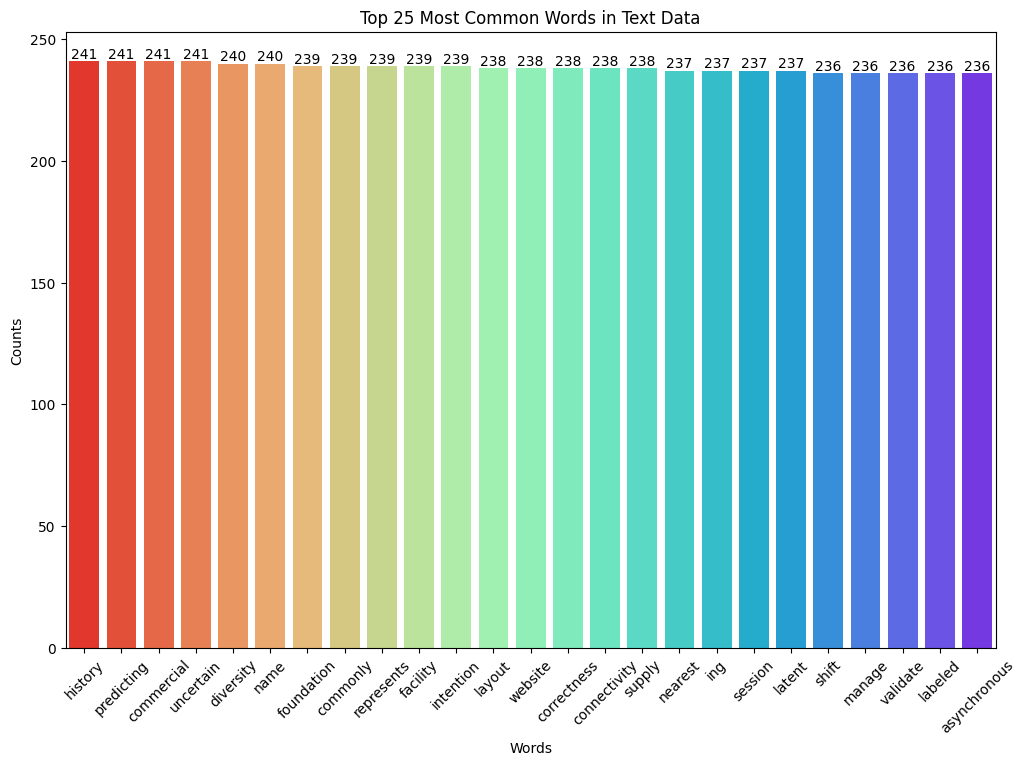

In [19]:
clean_word_counts = word_occurrences(data_text, visualisation=True)


In [20]:
# save data_text variable as a CSV file
data_text.to_csv("data_text.csv", index=False)


---

## 2. Mise en place du moteur de recherche


In [21]:
# Nous allons maintenant construire la matrice Documents x Termes en adoprant le schéma de pondération TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Define the vectorizer
tf_vectorizer = TfidfVectorizer(use_idf=False)
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the vectorizer on the 'text' column
X_tf = tf_vectorizer.fit_transform(data_text["text"])
X_tfidf = tfidf_vectorizer.fit_transform(data_text["text"])

# Show the shape of the resulting matrix
X_tfidf.shape


(40596, 8409)

In [22]:
requete = ["representation", "learning", "for", "natural", "language", "processing"]

pseudo_document_tf = tf_vectorizer.transform([" ".join(requete)])
pseudo_document_tfidf = tfidf_vectorizer.transform([" ".join(requete)])

# Calculer les similarités cosinus entre le pseudo-document et les documents
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

similarities_tf = cosine_similarity(X_tf, pseudo_document_tf)
similarities_tfidf = cosine_similarity(X_tfidf, pseudo_document_tfidf)

# Afficher les 5 documents les plus similaires
top5_tf = np.argsort(similarities_tf.flatten())[::-1][:5]
top5_tfidf = np.argsort(similarities_tfidf.flatten())[::-1][:5]

print(f"TF    : {top5_tf} | {similarities_tf[top5_tf].flatten()}")
print(
    data_text.iloc[top5_tf].drop(columns=["text", "abstract", "references"]), "\n\n\n\n"
)

print(f"TFIDF : {top5_tfidf} | {similarities_tfidf[top5_tfidf].flatten()}")
print(data_text.iloc[top5_tfidf].drop(columns=["text", "abstract", "references"]))


# print(data_text.iloc[top5_tf]["title"], '\n\n\n\n')
# print(data_text.iloc[top5_tfidf]["title"])


TF    : [    0 40595 40594 40593    16] | [0. 0. 0. 0. 0.]
                                                   venue  \
0      international conference on human-computer int...   
40595                            Object Oriented Systems   
40594  european conference on information warfare and...   
40593     pacific asia conference on information systems   
16     international conference on human computer int...   

                                                 authors  n_citation  \
0      ['Makoto Satoh', 'Ryo Muramatsu', 'Mizue Kayam...           0   
40595  ['Jin Song Dong', 'Roger Duke', 'Gordon A. Rose']           9   
40594  ['Rauno Kuusisto', 'Tuija Kuusisto', 'Leigh Ar...           4   
40593            ['Qian Li', 'Yu Chen', 'Lanfang Zhang']           0   
16               ['Hiroshi Furukawa', 'Yutaka Nakamura']           7   

                                                   title  year  \
0      Preliminary Design of a Network Protocol Learn...  2013   
40595  An objec

In [23]:
requete = ["representation", "learning", "for", "natural", "language", "processing"]

pseudo_document_tf = tf_vectorizer.transform([" ".join(requete)])
pseudo_document_tfidf = tfidf_vectorizer.transform([" ".join(requete)])

# Calculer les similarités cosinus entre le pseudo-document et les documents
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

similarities_tf = cosine_similarity(X_tf, pseudo_document_tf)
similarities_tfidf = cosine_similarity(X_tfidf, pseudo_document_tfidf)

# Afficher les 5 documents les plus similaires
top5_tf = np.argsort(similarities_tf.flatten())[::-1][:5]
top5_tfidf = np.argsort(similarities_tfidf.flatten())[::-1][:5]

print(f"TF    : {top5_tf} | {similarities_tf[top5_tf].flatten()}")
print(
    data_text.iloc[top5_tf].drop(columns=["text", "abstract", "references"]), "\n\n\n\n"
)

print(f"TFIDF : {top5_tfidf} | {similarities_tfidf[top5_tfidf].flatten()}")
print(data_text.iloc[top5_tfidf].drop(columns=["text", "abstract", "references"]))


# print(data_text.iloc[top5_tf]["title"], '\n\n\n\n')
# print(data_text.iloc[top5_tfidf]["title"])


TF    : [    0 40595 40594 40593    16] | [0. 0. 0. 0. 0.]
                                                   venue  \
0      international conference on human-computer int...   
40595                            Object Oriented Systems   
40594  european conference on information warfare and...   
40593     pacific asia conference on information systems   
16     international conference on human computer int...   

                                                 authors  n_citation  \
0      ['Makoto Satoh', 'Ryo Muramatsu', 'Mizue Kayam...           0   
40595  ['Jin Song Dong', 'Roger Duke', 'Gordon A. Rose']           9   
40594  ['Rauno Kuusisto', 'Tuija Kuusisto', 'Leigh Ar...           4   
40593            ['Qian Li', 'Yu Chen', 'Lanfang Zhang']           0   
16               ['Hiroshi Furukawa', 'Yutaka Nakamura']           7   

                                                   title  year  \
0      Preliminary Design of a Network Protocol Learn...  2013   
40595  An objec

In [24]:
# ecrire meme code que cellule avant just change le score de similarité a distance euclidienne
similarities_tf = euclidean_distances(X_tf, pseudo_document_tf)
similarities_tfidf = euclidean_distances(X_tfidf, pseudo_document_tfidf)

# Afficher les 5 documents les plus similaires
top5_tf = np.argsort(similarities_tf.flatten())[::-1][:5]
top5_tfidf = np.argsort(similarities_tfidf.flatten())[::-1][:5]

print(f"TF    : {top5_tf} | {similarities_tf[top5_tf].flatten()}")
print(
    data_text.iloc[top5_tf].drop(columns=["text", "abstract", "references"]), "\n\n\n\n"
)

print(f"TFIDF : {top5_tfidf} | {similarities_tfidf[top5_tfidf].flatten()}")
print(data_text.iloc[top5_tfidf].drop(columns=["text", "abstract", "references"]))


TF    : [17317 12092 27823  2516  9978] | [1. 1. 1. 1. 1.]
                                                   venue  \
17317                    Computer Physics Communications   
12092          Autonomous Agents and Multi-Agent Systems   
27823          scandinavian conference on image analysis   
2516   International Journal of Unconventional Computing   
9978   pacific-rim symposium on image and video techn...   

                                                 authors  n_citation  \
17317                                 ['Gary N. Felder']          50   
12092  ['Gal A. Kaminka', 'Ian Frank', 'Katsuto Arai'...          50   
27823   ['Ali Alsam', 'Puneet Sharma', 'Anette Wrålsen']          50   
2516   ['Hajo Broersma', 'Faustino J. Gomez', 'Julian...          35   
9978                      ['Daw-Tung Lin', 'Mingju Liu']          13   

                                                   title  year  \
17317  CLUSTEREASY: A program for lattice simulations...  2008   
12092  Performa

Talk about :

- TF requiring stopwords removed, and TDIDF requiring stop words not removed
- Euclidian distances donc function in higher dimensions (if you do TF and TFIDF scores with euclidian distances, you'll get the exact same score every time (curse of high dimensionnality))
- Don't remove stopwords ?


In [25]:
# save X_tf and X_tfidf as numpy matrix
np.save("X_tf.npy", X_tf)
np.save("X_tfidf.npy", X_tfidf)


In [26]:
X_tf.shape


(40596, 8409)